Code to preprocess the CUT&RUN data and get allele specific TF occupancy. This is a later stage script important in evaluation and you'll probably have a better hang of the whole pipeline by then, so I'll save the cleaning/documentation for a later date.

In [1]:
# General import, names of train, test, val
import numpy as np
import pysam
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt

basedir = '/data/leslie/shared/ASA/'
ctype = 'cd8'

aligndir = f'{basedir}pseudodiploid/cutrun/{ctype}/tbet/'
datadir = f'{basedir}mouseASA/{ctype}/cast/data/cutrun/tbet/'
chroms = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

reps = ['r1','r2']
seqlen = 300                         # region around summit for sequence
save = True

# Get intersection of ATAC and CUT&RUN peaks

In [32]:
# get dataframe of ATAC summits
summits = pd.read_csv(f'{basedir}pseudodiploid/atac/cd8_old/yi_cd8_peaks_33143.csv', sep=',', index_col=0)
summits['start'] += 150
summits = summits.iloc[:,1:3]
summits.columns = range(2)
summits.sort_values([0,1], inplace=True, ignore_index=True)
summits[2] = False

# get dataframe of CUT&RUN peak calls
peaks = pd.read_csv(f'{aligndir}peaks/peakatlas.bed', sep='\t', header=None)
# filter CUTRUN peaks by IDR
idr_thresh = 0.05
idx = np.where(peaks[11]>-np.log10(idr_thresh))[0]
peaks = peaks.iloc[idx,:].reset_index(drop=True)
peaks = peaks.iloc[:,:3]

In [33]:
# Shortlist ATAC summits that lie in CUT&RUN peak regions

for c in tqdm(np.unique(summits[0])):     # iterate over all chromosomes in the ATAC summits
    chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]
    chrompeaks = peaks.iloc[np.where(peaks[0]==c)[0],1:]
    # get indices of the summits that lie in CUT&RUN peak regions
    temp = []
    for i in chromsummits:
        temp.append(np.any((chrompeaks[1]<i)*(chrompeaks[2]>i))) # for each summit check if it lies in some peak region
    summits.iloc[np.where(summits[0]==c)[0],2] = temp

# Filter out the summits
summits = summits.loc[summits[2], :1].reset_index(drop=True)

  0%|          | 0/19 [00:00<?, ?it/s]

# Get allele specific CUT&RUN pileups on filtered ATAC summits

In [35]:
import os
# some utility functions
from utils import get_shifts, one_hot, GCregress

# make data directory for the cell type
if not os.path.exists(datadir):
    os.makedirs(datadir)
    # separate out replicate BAM files based on allele tag wA, to be used for pileup purposes
    for rep in tqdm(reps):
        bamfile = aligndir+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
        _ = pysam.index(bamfile)
        bamf = pysam.AlignmentFile(bamfile, "rb")
        temp1 = pysam.AlignmentFile(datadir+rep+'_b6.bam', 'wb', template=bamf)
        temp2 = pysam.AlignmentFile(datadir+rep+'_cast.bam', 'wb', template=bamf)
        temp3 = pysam.AlignmentFile(datadir+rep+'_both.bam', 'wb', template=bamf)
        i=0
        for read in bamf.fetch():
            try:
                idx = read.get_tag('wA')
                if idx==0:
                    temp1.write(read)
                elif idx==1:
                    temp2.write(read)
                elif idx==2:
                    temp3.write(read)
            except:
                i+=1
        print(i)
        temp1.close()
        temp2.close()
        temp3.close()
        bamf.close()

        _ = pysam.index(datadir+rep+'_b6.bam')
        _ = pysam.index(datadir+rep+'_cast.bam')
        _ = pysam.index(datadir+rep+'_both.bam')

In [36]:
# Use summits and BAM files to generate pileup summed accessibilities
y = dict()
for rep in tqdm(reps):
    temp1 = pysam.AlignmentFile(datadir+rep+'_b6.bam', 'rb')
    temp2 = pysam.AlignmentFile(datadir+rep+'_cast.bam', 'rb')

    y[rep+'_b6'] = []
    y[rep+'_cast'] = []

    for c in chroms:        # for each chromosome
        chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
        y_b6 = []
        y_cast = []
        for i in chromsummits:
            # for each summit peak, get the summed accessibility from BAM pileup
            y1 = temp1.count(str(c),i-seqlen//2,i+seqlen//2)
            y2 = temp2.count(str(c),i-seqlen//2,i+seqlen//2)
            y_b6.append(y1)
            y_cast.append(y2)            

        y[rep+'_b6'] += y_b6
        y[rep+'_cast'] += y_cast
    
    temp1.close()
    temp2.close()
    
del y_b6, y_cast, y1, y2, chromsummits

y['b6'] = np.zeros_like(y[rep+'_b6'])
y['cast'] = np.zeros_like(y[rep+'_cast'])
for rep in reps:
    y['b6'] += np.array(y[rep+'_b6'])
    y['cast'] += np.array(y[rep+'_cast'])
    del y[rep+'_b6'], y[rep+'_cast']

  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
temp1 = np.abs(y['b6']-y['cast'])        # difference in coverage
temp2 = np.abs(y['b6']-y['cast'])/(y['b6']+y['cast'])      # exclusiveness of coverage
temp2[np.isnan(temp2)] = 0

/scratch/lsftmp/418244.tmpdir/ipykernel_40490/2206246405.py:2: RuntimeWarning: invalid value encountered in true_divide
  temp2 = np.abs(y['b6']-y['cast'])/(y['b6']+y['cast'])      # exclusiveness of coverage


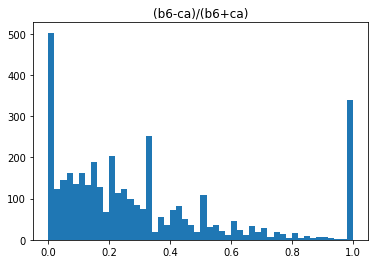

In [38]:
plt.hist(temp2, bins=50)
plt.title('(b6-ca)/(b6+ca)')
plt.show()

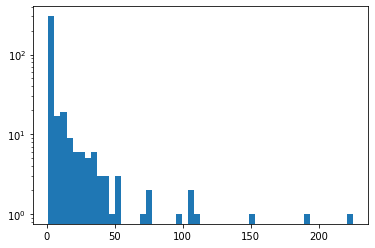

In [39]:
plt.hist(temp1[temp2>0.8], bins=50, log=True)
plt.show()

In [43]:
# Filter summits to differential TF occupancy
idx = np.where(temp2>0.8)[0]
summits = summits.iloc[idx,:].reset_index(drop=True)
summits[2] = temp1[temp2>0.8]
summits[3] = y['b6'][temp2>0.8]
summits[4] = y['cast'][temp2>0.8]
summits.sort_values(2, ascending=False, inplace=True, ignore_index=True)
summits.columns = ['chr', 'summit', 'diff', 'b6', 'ca']

# Save
if save:
    summits.to_csv(f'{datadir}summits_tbetfiltered.csv', index=False)

# Get pileups around the filtered summits

In [31]:
summits = pd.read_csv(f'{datadir}summits_tbetfiltered.csv')
summits.head()

,chr,summit,diff,b6,ca
0,17,70963761,225,25,250
1,2,5379287,190,6,196
2,7,130834538,150,5,155
3,9,110281308,110,4,114
4,2,69380492,108,110,2


In [23]:
# Get pileups on the filtered summits
y = dict()
for rep in tqdm(reps):
    temp1 = pysam.AlignmentFile(datadir+rep+'_b6.bam', 'rb')
    temp2 = pysam.AlignmentFile(datadir+rep+'_cast.bam', 'rb')

    y[rep+'_b6'] = np.zeros((len(summits), seqlen), dtype=np.int8)
    y[rep+'_cast'] = np.zeros((len(summits), seqlen), dtype=np.int8)
    
    for i in range(len(summits)):
        temp = summits.iloc[i]
        y[rep+'_b6'][i] = np.sum(temp1.count_coverage(str(temp[0]), temp[1]-seqlen//2, temp[1]+seqlen//2), axis=0)
        y[rep+'_cast'][i] = np.sum(temp2.count_coverage(str(temp[0]), temp[1]-seqlen//2, temp[1]+seqlen//2), axis=0)

y['b6'] = np.zeros_like(y[rep+'_b6'])
y['cast'] = np.zeros_like(y[rep+'_cast'])
for i,rep in enumerate(reps):
    y['b6'] += np.array(y[rep+'_b6'])
    y['cast'] += np.array(y[rep+'_cast'])
    del y[rep+'_b6'], y[rep+'_cast']

if save:
    with h5py.File(datadir+'profiles.h5','w') as f:
        for key in y.keys():
            f.create_dataset('profile_'+key, data=y[key])

  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
if save:
    with h5py.File(datadir+'profiles.h5','w') as f:
        for key in y.keys():
            f.create_dataset('profile_'+key, data=y[key])

In [5]:
y = dict()
with h5py.File(datadir+'profiles.h5','r') as f:
    y['b6'] = f['profile_b6'][()]
    y['cast'] = f['profile_cast'][()]

In [25]:
summits.head(50)

,chr,summit,diff,b6,ca
0,17,70963761,225,25,250
1,2,5379287,190,6,196
2,7,130834538,150,5,155
3,9,110281308,110,4,114
4,2,69380492,108,110,2
5,18,85698032,108,6,114
6,8,3754448,96,8,104
7,9,108144752,75,7,82
8,5,137857059,73,76,3
9,15,86195220,71,3,74


chr            12
summit    4065711
diff           25
b6             25
ca              0
Name: 34, dtype: int64


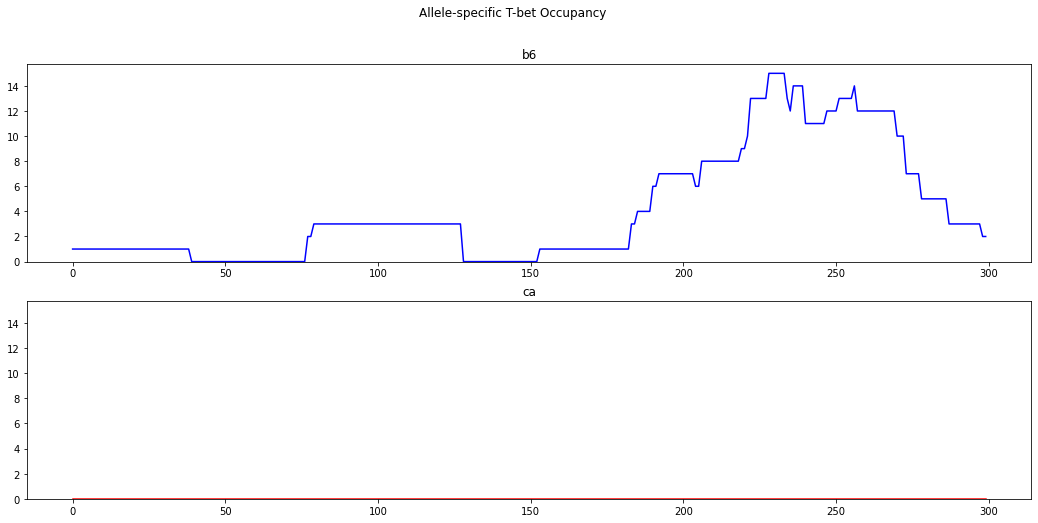

In [27]:
fig, ax = plt.subplots(2,1, figsize=(18,8))
i = 34
ylim = np.max(np.concatenate((y['b6'][i],y['cast'][i])))*1.05
ax[0].plot(y['b6'][i], color='b')
ax[1].plot(y['cast'][i], color='r')
ax[0].set_title('b6')
ax[1].set_title('ca')
ax[0].set_ylim([0,ylim])
ax[1].set_ylim([0,ylim])
plt.suptitle('Allele-specific T-bet Occupancy')
print(summits.iloc[i])
plt.show()